# Streaming Application
This code consumes the data sent by the producer under the `flighTopic`. Then we conver the dictionaries consume to a dataset format and create new labels based on the value of `ARRIVAL_LABEL` and `DEPARTURE_DELAY`. Afterward, we create the parquet files so they can be read later. And finally, we aggregate this data and calculate the accuracies to be plotted

### Step 1
Initialize Spark Session, in this section we imported all the libraries needed, we used `2 cores` and we set the time zone to `UTC`, and we created the `Spark Session`

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml import PipelineModel

master = "local[2]"
app_name = "Flights Stream Application"

spark_conf = SparkConf().setMaster(master)\
                .setAppName(app_name)\
                .set("spark.sql.session.timeZone", "UTC")

spark = SparkSession \
        .builder \
         .config(conf=spark_conf) \
         .getOrCreate()

### Step 2
Connection to Kafka Producer/Broker and subscribe to the topic `filghtTopic` and load data from there with <code>readStream</code>. Converting the key/value from the kafka data stream to string

In [35]:
topic = "flight_Topic"
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

### Step 3
Converting the incoming stream into dataframe based on the schema. Note that, were are receiving a list from the producer, so the schema and other transformations are done accordingly. Besides we created the labels using the columns `ARRIVAL_DELAY` and `DEPARTURE_DELAY`. If those values are higer that 0 we set the labels as 1 otherwise we set the label as 0

In [36]:
#Define the schema for the structured datastream received
schema = ArrayType(StructType([    
    StructField('ts', TimestampType(), True), 
    StructField('YEAR', IntegerType(), True),
    StructField('MONTH', IntegerType(), True),
    StructField('DAY', IntegerType(), True),
    StructField('DAY_OF_WEEK', IntegerType(), True),
    StructField('AIRLINE', StringType(), True),
    StructField('FLIGHT_NUMBER', IntegerType(), True),
    StructField('TAIL_NUMBER', StringType(), True),
    StructField('ORIGIN_AIRPORT', StringType(), True),
    StructField('DESTINATION_AIRPORT', StringType(), True),
    StructField('SCHEDULED_DEPARTURE', IntegerType(), True),
    StructField('DEPARTURE_TIME', FloatType(), True), # Integer review NA values
    StructField('DEPARTURE_DELAY', FloatType(), True), # Integer review NA values
    StructField('TAXI_OUT', FloatType(), True), # Integer review NA values    
    StructField('WHEELS_OFF', FloatType(), True),    # Integer review NA values 
    StructField('SCHEDULED_TIME', IntegerType(), True),
    StructField('ELAPSED_TIME', FloatType(), True), # Integer review NA values 
    StructField('AIR_TIME', FloatType(), True), # Integer review NA values
    StructField('DISTANCE', IntegerType(), True),
    StructField('WHEELS_ON', FloatType(), True),  # Integer review NA values
    StructField('TAXI_IN', FloatType(), True),  # Integer review NA values
    StructField('SCHEDULED_ARRIVAL', IntegerType(), True),
    StructField('ARRIVAL_TIME', FloatType(), True),  # Integer review NA values
    StructField('ARRIVAL_DELAY', FloatType(), True),  # Integer review NA values
    StructField('DIVERTED', IntegerType(), True),
    StructField('CANCELLED', IntegerType(), True)
    ]))
    
    # We are not going to include these columns as they were removed before because most of the values were NA,
    # We leave them here to raise awareness that we do considered them 
    
    #StructField('CANCELLATION_REASON', StringType(), True),
    #StructField('AIR_SYSTEM_DELAY', StringType(), True),
    #StructField('SECURITY_DELAY', StringType(), True),
    #StructField('AIRLINE_DELAY', StringType(), True),
    #StructField('LATE_AIRCRAFT_DELAY', StringType(), True),
    #StructField('WEATHER_DELAY', StringType(), True),


df = df.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value'))
# flatten nested columns
df_formatted = df.select(F.explode(F.col("parsed_value")).alias('unnested_value')).select('unnested_value.*')
df_formatted = df_formatted.withColumn("binaryArrDelay", F.when(df_formatted.ARRIVAL_DELAY > 0, 1).otherwise(0))
df_formatted = df_formatted.withColumn("binaryDeptDelay", F.when(df_formatted.DEPARTURE_DELAY > 0, 1).otherwise(0))
df_formatted.printSchema()

root
 |-- ts: timestamp (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: float (nullable = true)
 |-- DEPARTURE_DELAY: float (nullable = true)
 |-- TAXI_OUT: float (nullable = true)
 |-- WHEELS_OFF: float (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: float (nullable = true)
 |-- AIR_TIME: float (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: float (nullable = true)
 |-- TAXI_IN: float (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: float (nullable = true)
 |-- ARRIVAL_D

### Step 4
Persist the raw streaming data in parquet format 

In [37]:
query_file_sink = df_formatted.writeStream\
                                 .format('parquet')\
                                 .outputMode("append") \
                                 .option('path', 'flight.parquet/flights')\
                                 .option('checkpointLocation', 'flight.parquet/flights/checkpoints')\
                                 .start()

In [38]:
#Stop the file_sink query
query_file_sink.stop()

In [39]:
# Read the saved parquet data
query_file_sink_df = spark.read.parquet("flight.parquet/flights")
query_file_sink_df.printSchema()
query_file_sink_df.show()

root
 |-- ts: timestamp (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: float (nullable = true)
 |-- DEPARTURE_DELAY: float (nullable = true)
 |-- TAXI_OUT: float (nullable = true)
 |-- WHEELS_OFF: float (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: float (nullable = true)
 |-- AIR_TIME: float (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: float (nullable = true)
 |-- TAXI_IN: float (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: float (nullable = true)
 |-- ARRIVAL_D

### Step 5
Using the Machine Learning model created in Assignment 2A to predict the label 

#### ARRIVAL DELAY
By just selecting the columns of interest and creating a new data frame `df_arrival`, we predict the values with the model imported

In [40]:
df_arrival = df_formatted.select('ts','AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DAY', 'ARRIVAL_TIME',
                                 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_DEPARTURE', 'MONTH', 'SCHEDULED_ARRIVAL', 'DAY_OF_WEEK',
                                 'TAXI_OUT', 'DISTANCE', 'DEPARTURE_TIME', 'binaryArrDelay')

model_Arr = PipelineModel.load('Arrival_Model')

# make prediction
predictions_Arr = model_Arr.transform(df_arrival)

After we have the prediction and the tru label for each flight, we proceed to group the data by `date`, `label`, and `prediction` and aggregate them by count so we can know the number of `True Positives`, `True Negatives`, `False Negatives` and `False Positives`

In [41]:
#Using the window function, we can perform the following aggregation 
confusion_matrix_arrival = predictions_Arr.groupBy(F.window("ts","5 second"), 
                                                      predictions_Arr.binaryArrDelay, 
                                                      predictions_Arr.prediction)\
                                            .agg(F.count("binaryArrDelay").alias("Count"))\
                                            .select(F.col("window.end").alias("end_time"),
                                                   F.col("binaryArrDelay"),
                                                   F.col("prediction"),
                                                   F.col("Count")
                                            )

After we build the confusion matrix of each batch, we stream it and send it to the memory every 5 seconds

In [47]:
query_predArr = confusion_matrix_arrival \
                        .writeStream \
                        .outputMode("complete") \
                        .format("memory") \
                        .queryName("confusion_matrix_arrival") \
                        .trigger(processingTime='5 seconds') \
                        .start()

In [46]:
query_predArr.stop()

And then we show the data frame sent 

In [43]:
spark.sql("select * from confusion_matrix_arrival").show()

+-------------------+--------------+----------+-----+
|           end_time|binaryArrDelay|prediction|Count|
+-------------------+--------------+----------+-----+
|2021-10-19 05:00:55|             1|       1.0|   66|
|2021-10-19 05:07:30|             0|       0.0|  395|
|2021-10-19 05:01:40|             0|       1.0|   25|
|2021-10-19 05:06:15|             0|       1.0|   23|
|2021-10-19 05:03:10|             1|       1.0|   67|
|2021-10-19 05:06:40|             0|       0.0|  395|
|2021-10-19 05:00:25|             1|       1.0|    2|
|2021-10-19 05:04:15|             1|       0.0|  168|
|2021-10-19 05:03:45|             1|       1.0|   67|
|2021-10-19 05:04:25|             1|       1.0|   65|
|2021-10-19 05:07:50|             1|       0.0|  164|
|2021-10-19 05:04:30|             0|       1.0|   25|
|2021-10-19 05:06:45|             0|       1.0|   22|
|2021-10-19 05:03:15|             0|       1.0|   26|
|2021-10-19 05:05:35|             1|       1.0|   71|
|2021-10-19 05:07:20|       

### Step 6


In [44]:
def init_plots():
    try:
        width = 18
        height = 12
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.title.set_text('Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


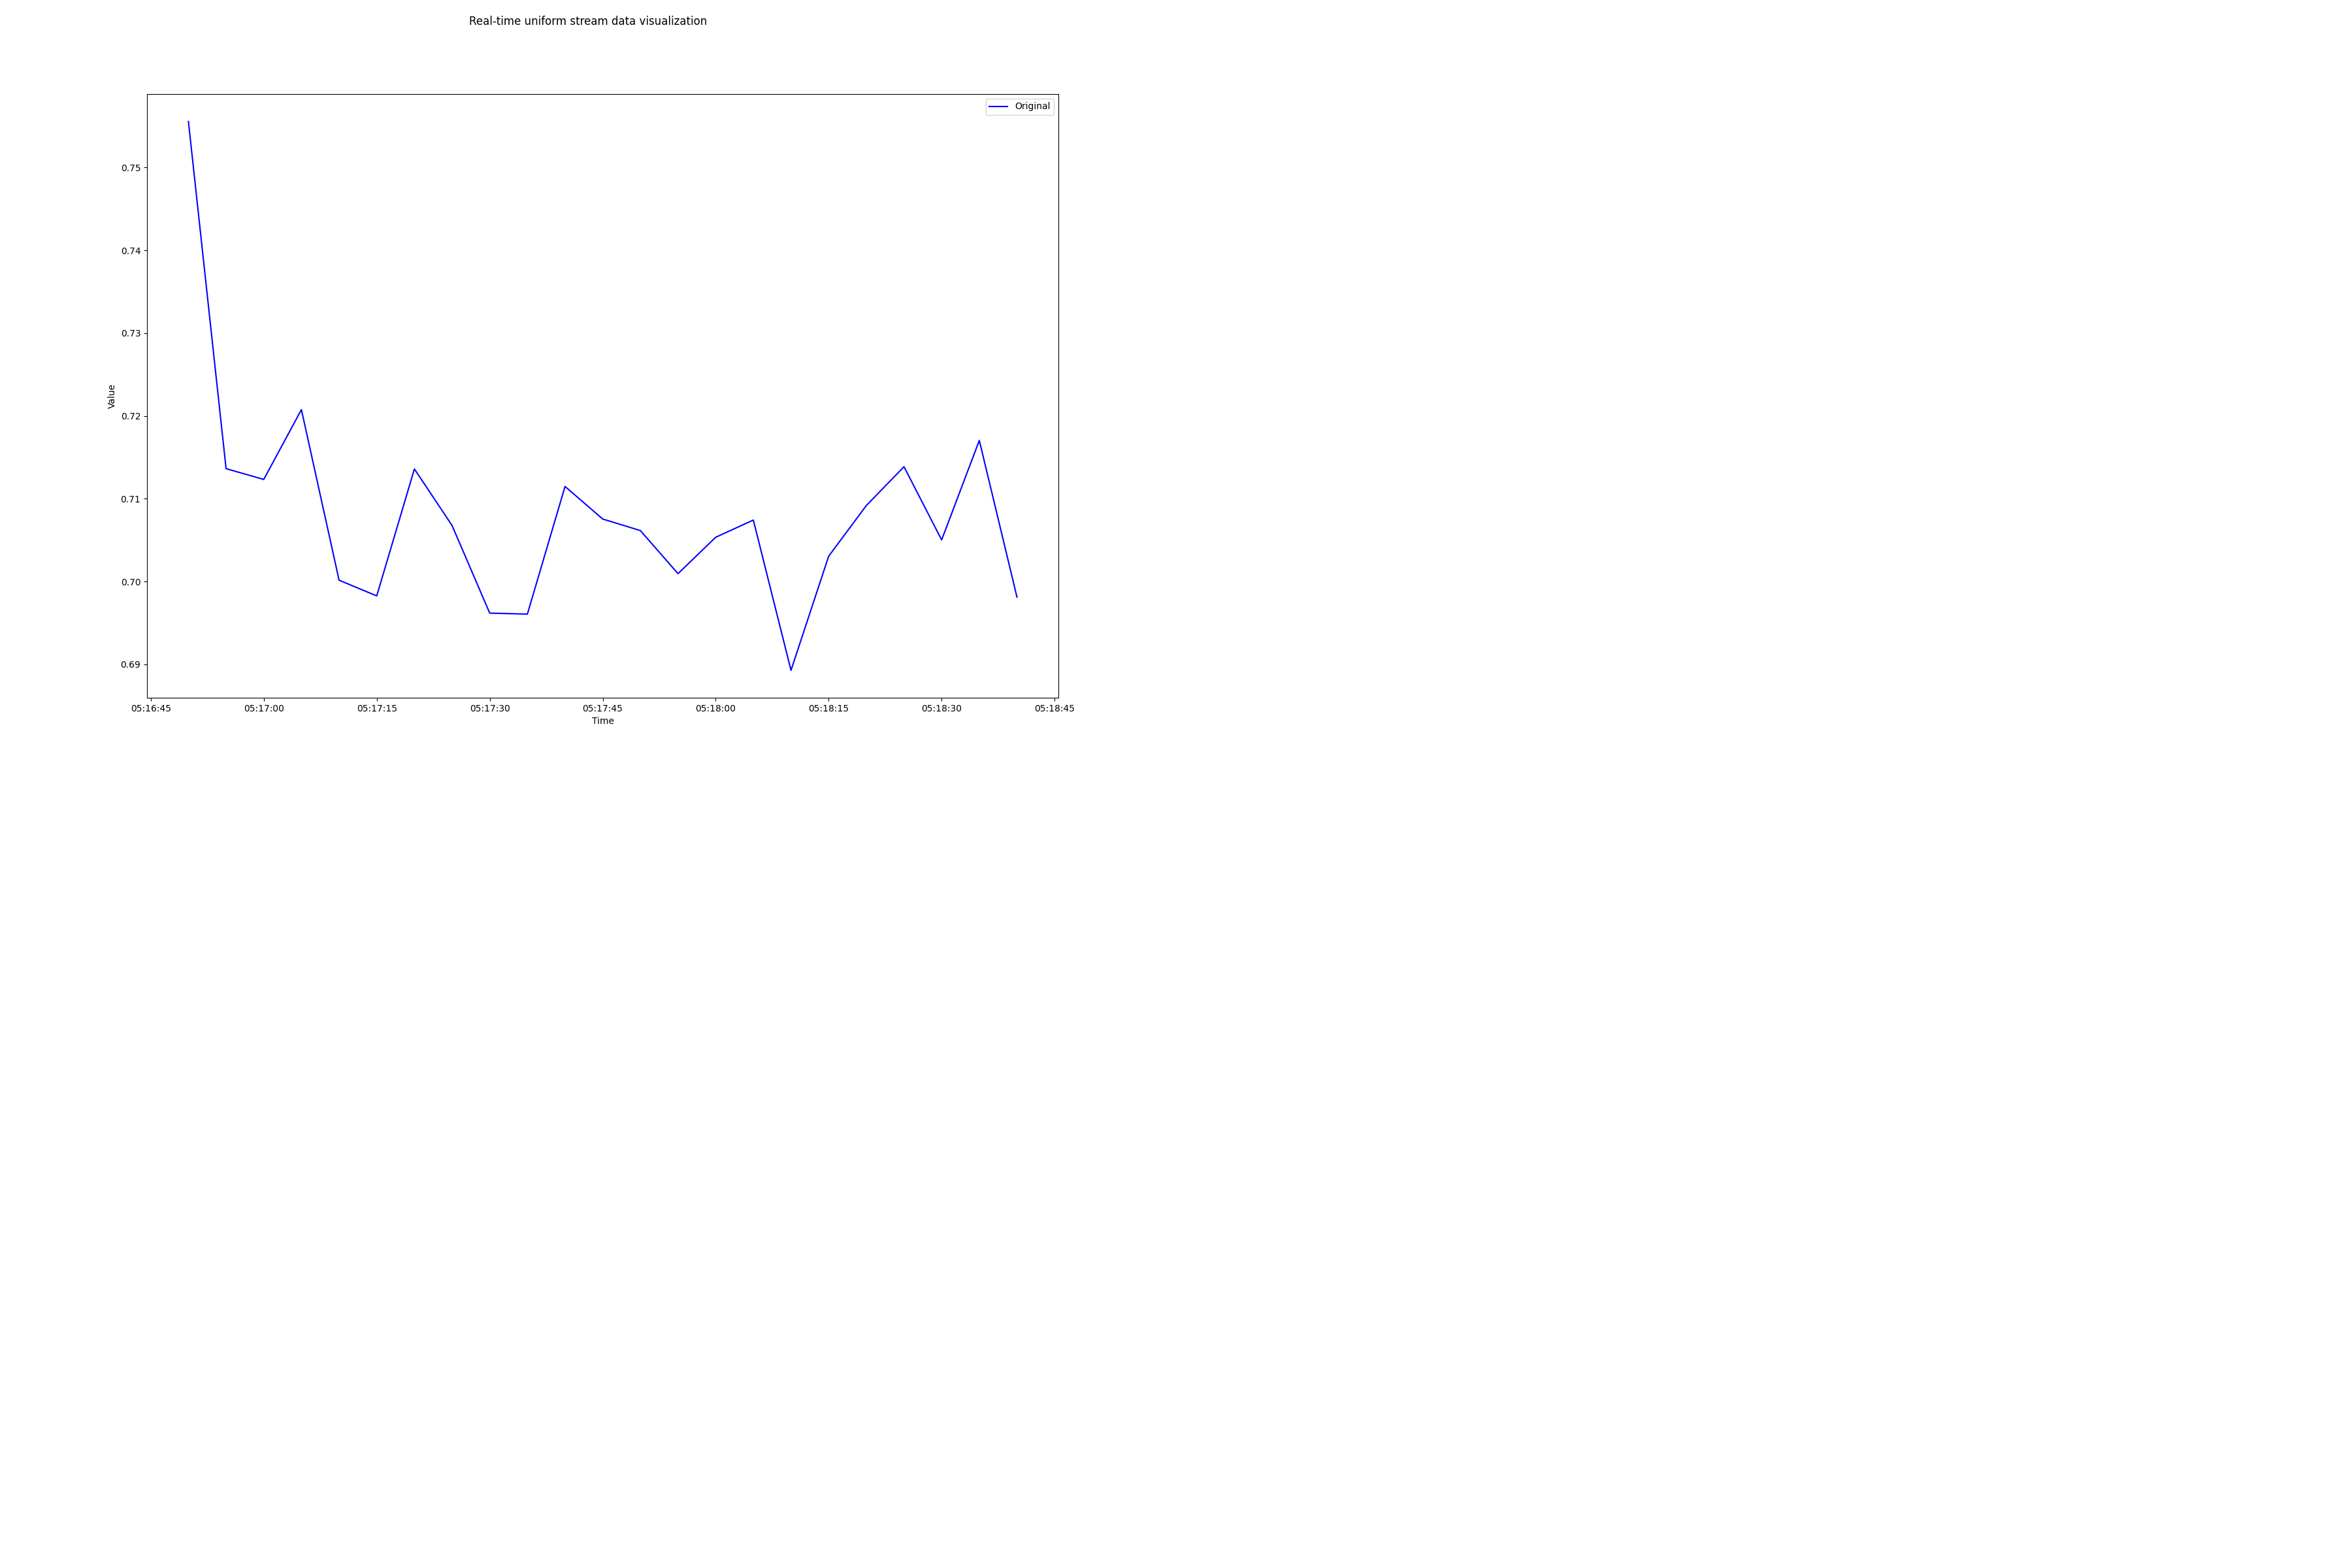

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    df_all = spark.sql("select * from confusion_matrix_arrival order by end_time desc limit 90").toPandas()
    df_all['True'] = df_all.Count[df_all['prediction'] == df_all['binaryArrDelay']]
    df_all['False'] = df_all.Count[df_all['prediction'] != df_all['binaryArrDelay']]
    df_all.fillna(0, inplace = True)
    df_all = df_all.groupby('end_time', as_index=False)[['True', 'False']].sum()
    df_all['Accuracy'] = df_all['True']/(df_all['True'] + df_all['False'])
    
    # Get starting timestamp to plot both graphs
    start_time = df_all['end_time'][len(df_all)-1]
    #df_reduced = spark.sql("select * from reduced_values where end_time>='"+str(start_time)+"' order by end_time desc").toPandas()
    
    x_all = df_all['end_time'].to_list()
    y_all = df_all['Accuracy'].to_list()
    #x_reduced = df_reduced['end_time'].to_list()
    #y_reduced = df_reduced['avg_value'].to_list()
    ax.clear()
    ax.plot(x_all, y_all, '-b', label='Original')
    #ax.plot(x_reduced, y_reduced, '--r', label='Reduced')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    leg = ax.legend()
    fig.canvas.draw()
    
    time.sleep(5)